# Testing area

## Step 1: Data Collection
First, gather the stock price history, trading volume, and other relevant indicators. Use the finvizfinance package to get stock data and a package like yahoo_fin for news. Ensure you have these packages installed.

In [1]:
# Install necessary libraries
# %pip install numpy pandas tensorflow scikit-learn nltk requests bs4 finvizfinance goose3 transformers yahoo-fin yfinance requests_html matplotlib tf-keras

In [2]:
# Standard library imports
from datetime import datetime, timedelta
import warnings

# Related third party imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import sent_tokenize
from requests import get

# Local application/library specific imports
from bs4 import BeautifulSoup                        # type: ignore
from finvizfinance.quote import finvizfinance
from goose3 import Goose                             # type: ignore
from transformers import AutoTokenizer               # type: ignore
from transformers import pipeline                    # type: ignore
from yahoo_fin import stock_info as si
from yahoo_fin import news
import yfinance as yf                                # type: ignore

warnings.filterwarnings('ignore')


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


# Step 2: Gather Stock Data
Fetch the stock price history and other indicators, like trading volume, for a specific ticker.

In [3]:
# Define a stock ticker symbol
TICKER = "AAPL"

# Get stock price history
stock_data = si.get_data(TICKER, start_date="2022-01-01")

# Include relevant features
stock_data["trading_volume"] = stock_data["volume"]
stock_data["price_change"] = stock_data["close"].diff()  # Daily price change


# Step 3: Fetch News and Analyze Sentiment
Fetch news articles related to the ticker and analyze their sentiment. This step might require additional sentiment analysis tools or pre-trained sentiment models.

In [5]:

def get_ticker_news_sentiment(ticker):

    ALLOW_TOKENIZATION = False # True: the model will feed the article into the model in chunks of 512 tokens, 
    #                            False: the model will consider only the first sentences of the article until the total number of tokens does not exceed 512

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

    ticker_news = yf.Ticker(ticker)
    try:
        news_list = ticker_news.get_news()
    except:
        print(f"Error getting news for ticker {ticker}")
        return
    
    extractor = Goose()
    pipe = pipeline("text-classification", model="ProsusAI/finbert")
    data = []
    
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
                
    for dic in news_list:
        title = dic['title']
        response = get(dic['link'], headers=headers)
        
        article = extractor.extract(raw_html=response.content)
        text = article.cleaned_text
        date = article.publish_date
        
        if date == None: # If the date is not found in the article, try to find it in the article's html
            soup = BeautifulSoup(response.text, 'html.parser')

            # Yahoo Finance usually stores the publication date in a 'time' tag with the class 'caas-attr-meta-time'
            date_tag = soup.find('time', {'class': 'caas-attr-meta-time'})
            if date_tag:
                date = date_tag['datetime']
            else:
                print('Publication date not found, article link for debugging', dic['link'])
            
            
        if len(text) > 512:
            if ALLOW_TOKENIZATION: # feed the article into the model in chunks of 512 tokens
                inputs = tokenizer.encode_plus(
                    text,
                    max_length=510,
                    truncation='longest_first',  # Truncate the longest sequences first
                    padding='max_length',  # Pad sequences to the max length
                    return_tensors='pt',  # Return PyTorch tensors
                )
                
                # Convert tensor to list and then to string
                input_ids = inputs["input_ids"].tolist()[0]
                new_text = tokenizer.decode(input_ids)
            
            else: # count the sentences until the total number of tokens does not exceed 512 (consider only first sentences of the article)
                # Split the text into sentences
                sentences = sent_tokenize(text)

                # Initialize an empty string for the new text
                new_text = ''

                # Add sentences to the new text until it exceeds 512 tokens
                for sentence in sentences:
                    if len(new_text.split()) + len(sentence) > 512:
                        new_text += ' ' + sentence
                    break

            # Now you can pass 'inputs' to your model
            results = pipe(new_text)

            data.append({'Ticker':f'{ticker}',
                         'Date':f'{date}',
                         'Article title':f'{title}',
                         'Article sentiment':results[0]['label']})

        else:
            results = pipe(text)
            data.append({'Ticker':f'{ticker}',
                         'Date':f'{date}',
                         'Article title':f'{title}',
                         'Article sentiment':results[0]['label']})
    df = pd.DataFrame(data)
    return df


news_df_orig = get_ticker_news_sentiment(TICKER)




Error getting news for ticker AAPL


# Step 4: Align News with Stock Data

Align the news sentiment data with the stock price history to create a unified dataset.

In [ ]:
# Create a copy of the stock data and news data (to avoid modifying/rerunning the code to get the original data)
stock_data_copy = stock_data.copy()
news_df_copy = news_df_orig.copy()

# Some data cleaning and preprocessing
news_df_copy = news_df_copy.rename(columns={
    'Ticker': 'Ticker',
    'Date': 'Article timestamp',
    'Article title': 'Article title',
})

sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

news_df_copy['Article sentiment'] = news_df_copy['Article sentiment'].map(sentiment_mapping)
news_df_copy = news_df_copy.drop(columns=['Ticker', 'Article title']) # Drop unnecessary columns

# Convert news timestamps to datetime
news_df_copy["Article timestamp"] = pd.to_datetime(news_df_copy["Article timestamp"])
news_df_copy["date"] = news_df_copy["Article timestamp"].dt.date

# Convert 'date' column to a DatetimeIndex
news_df_copy['date'] = pd.to_datetime(news_df_copy['date'])

# Set 'date' as the index
news_df_copy.set_index('date', inplace=True)

# Now resample news_df
news_daily_sentiment = news_df_copy.resample("D").mean()


# Merge stock data with daily news sentiment
merged_data = stock_data_copy.join(news_daily_sentiment, how='left')

# Fill NaNs with neutral sentiment (0) if there are no news articles for a given day
merged_data["Article sentiment"] = merged_data["Article sentiment"].fillna(0)

    # Feature engineering: additional features like moving averages
if "MA_10" not in merged_data.columns: # Run this block only once
    merged_data["MA_10"] = merged_data["close"].rolling(window=10).mean()  # 10-day moving average
    merged_data["MA_200"] = merged_data["close"].rolling(window=200).mean()  # 200-day moving average (not used yet)

merged_data

,open,high,low,close,adjclose,volume,ticker,trading_volume,price_change,Article timestamp,Article sentiment,MA_10,MA_200
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.724548,104487900,AAPL,104487900,NaN,NaT,0.0,NaN,NaN
2022-01-04,182.630005,182.940002,179.119995,179.699997,177.443573,99310400,AAPL,99310400,-2.309998,NaT,0.0,NaN,NaN
2022-01-05,179.610001,180.169998,174.639999,174.919998,172.723587,94537600,AAPL,94537600,-4.779999,NaT,0.0,NaN,NaN
2022-01-06,172.699997,175.300003,171.639999,172.000000,169.840256,96904000,AAPL,96904000,-2.919998,NaT,0.0,NaN,NaN
2022-01-07,172.889999,174.139999,171.029999,172.169998,170.008102,86709100,AAPL,86709100,0.169998,NaT,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,172.509995,173.419998,170.889999,173.029999,173.029999,94214900,AAPL,94214900,3.729996,NaT,0.0,169.211000,181.24575
2024-05-03,186.649994,187.000000,182.660004,183.380005,183.380005,163224100,AAPL,163224100,10.350006,NaT,0.0,171.049001,181.18715
2024-05-06,182.350006,184.199997,180.419998,181.710007,181.710007,78569700,AAPL,78569700,-1.669998,NaT,0.0,172.636002,181.13005
2024-05-07,183.449997,184.899994,181.320007,182.399994,182.399994,77305800,AAPL,77305800,0.689987,NaT,0.0,174.186002,181.08235


# Step 5: Build and Train the Neural Network
Create and train the neural network to predict future stock prices based on the collected features.

In [ ]:

train_data = merged_data.copy()

# Define features and targets
features = train_data[["close", "trading_volume", "Article sentiment", "MA_10"]]
target = train_data["close"].shift(-1)  # Predict the next day's closing price

# Combine features and target into one DataFrame
data = features.copy()
data['target'] = target

# Drop rows with NaN values
data.dropna(subset=['MA_10', 'target'], inplace=True)

# Separate features and target
features = data.drop(columns='target')
target = data['target']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define the neural network architecture
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_shape=(4,)),  # 4 input features
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # Output layer with one node (regression)
])

# Compile the model with an optimizer and a loss function
model.compile(optimizer="adam", loss="mse")

# Train the model with the training set and validate with the validation set
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

(580,)
(580, 4)


Epoch 1/10

15/15 [==============================] - 25s 53ms/step - loss: 27991.9668 - val_loss: 26294.5781
Epoch 2/10
15/15 [==============================] - 0s 6ms/step - loss: 27717.5762 - val_loss: 25981.5293
Epoch 3/10
15/15 [==============================] - 0s 8ms/step - loss: 27305.4512 - val_loss: 25486.0293
Epoch 4/10
15/15 [==============================] - 0s 6ms/step - loss: 26652.9844 - val_loss: 24705.0430
Epoch 5/10
15/15 [==============================] - 0s 7ms/step - loss: 25618.0059 - val_loss: 23505.1699
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 24107.1270 - val_loss: 21806.8125
Epoch 7/10
15/15 [==============================] - 0s 16ms/step - loss: 22029.0352 - val_loss: 19574.8535
Epoch 8/10
15/15 [==============================] - 0s 8ms/step - loss: 19303.3262 - val_loss: 16832.7617
Epoch 9/10
15/15 [==============================] - 0s 7ms/step - loss: 16046.4062 - val_loss: 13708.2070
Epoch 10/10
15/15 [=====

# Step 6: Backtesting and Evaluation
Before deploying the model in a real-world scenario, it's crucial to evaluate its performance using backtesting. This process involves simulating how the model would perform in historical scenarios to ensure accuracy and stability.

This step calculates Mean Squared Error (MSE) and Mean Absolute Error (MAE) to evaluate how well the model predicts future stock prices. Consider expanding the metrics to evaluate different aspects of the model's performance.

In [ ]:
# Define a backtesting period
backtest_start = "2023-01-01"
backtest_end = "2024-01-01"

# Retrieve historical data for backtesting
backtest_data = si.get_data(TICKER, start_date=backtest_start, end_date=backtest_end)

if "MA_10" not in backtest_data.columns: # Run this block only once
    backtest_data["MA_10"] = backtest_data["close"].rolling(window=10).mean()  # 10-day moving average
    # Drop rows with NaN in 'MA_10'
    backtest_data = backtest_data.dropna(subset=['MA_10'])
    # backtest_data["Article sentiment"] = get_ticker_news_sentiment(ticker_symbol) # fix in the future
    backtest_data["Article sentiment"] = 0 # Dummy value for now, all neutral news sentiments


# Create future price targets for backtesting
backtest_data["future_stock_price"] = backtest_data["close"].shift(-1)

# Rename column
backtest_data = backtest_data.rename(columns={"volume": "trading_volume"})


print(backtest_data)

# Drop NaN values
backtest_features = backtest_data[["close", "trading_volume", "Article sentiment", "MA_10"]]
backtest_target = backtest_data["future_stock_price"].dropna()

# Normalize backtesting features
backtest_features_scaled = scaler.transform(backtest_features.dropna())

# Assuming model is your trained model
backtest_predictions = model.predict(backtest_features_scaled[:len(backtest_target)])

# Calculate metrics to assess performance
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(backtest_target, backtest_predictions)
mae = mean_absolute_error(backtest_target, backtest_predictions)

print(f"Backtesting MSE: {mse}")
print(f"Backtesting MAE: {mae}")


# Step 7: Stock Price Prediction

The plot below shows the actual and predicted stock prices. The actual prices are shown in blue and the predicted prices are shown in red.


C:\Users\Oskar\AppData\Local\Temp\ipykernel_12792\2598581434.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sentiments[i] == 1:
C:\Users\Oskar\AppData\Local\Temp\ipykernel_12792\2598581434.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif sentiments[i] == -1:


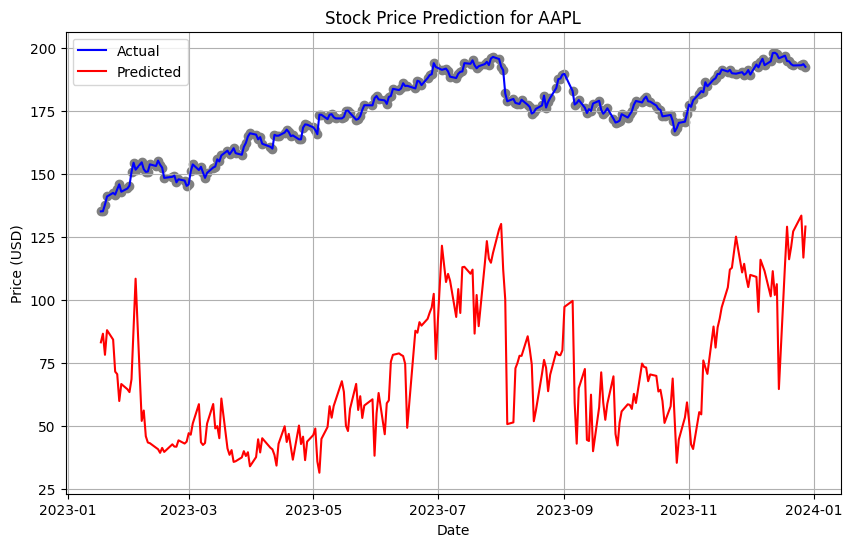

In [ ]:
import matplotlib.pyplot as plt
# Create a new figure
plt.figure(figsize=(10, 6))

# Get the dates corresponding to the targets
dates = backtest_data.index[:len(backtest_target)]

# Plot the actual values
plt.plot(dates, backtest_target.values, color='blue', label='Actual')

# Plot the predicted values
plt.plot(dates, backtest_predictions, color='red', label='Predicted')

# Get the sentiment values corresponding to the targets
sentiments = backtest_data['Article sentiment'][:len(backtest_target)]

# Plot the sentiment values as colored dots on the predicted values
for i in range(len(sentiments)):
    if sentiments[i] == 1:
        plt.scatter(dates[i], backtest_predictions[i], color='green')
    elif sentiments[i] == -1:
        plt.scatter(dates[i], backtest_predictions[i], color='red')
    else:
        plt.scatter(dates[i], backtest_predictions[i], color='gray')

# Plot the sentiment values as colored dots on the actual values
for i in range(len(sentiments)):
    if sentiments[i] == 1:
        plt.scatter(dates[i], backtest_target.values[i], color='green')
    elif sentiments[i] == -1:
        plt.scatter(dates[i], backtest_target.values[i], color='red')
    else:
        plt.scatter(dates[i], backtest_target.values[i], color='gray')

# Set the plot title and labels
plt.title(f'Stock Price Prediction for {TICKER}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Show legend
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

# Step 8: Implement Online Learning (Continuous Model Updates) (not implemented yet)
To implement a form of online learning, you need to define a process to update the model with new incoming data, thus allowing the model to continuously learn and adapt to changing market conditions.

Collect New Data: Fetch recent stock data and news articles. Align the news sentiment with stock prices.
Feature Engineering and Normalization: Ensure new data is prepared similarly to the original training data, including feature normalization.
Update the Model: Use the new data to continue training the model, simulating online learning. This may involve retraining the model for a few epochs with recent data.
Performance Monitoring: Track key metrics like MSE and Mean Absolute Error (MAE) to detect model drift. Define thresholds to trigger retraining when necessary.

In [ ]:
'''
from datetime import datetime, timedelta
from yahoo_fin import news
'''

# Step 9: Continuous Monitoring and Model Drift Detection (not implemented yet)
Given the dynamic nature of stock markets, it's critical to continuously monitor the model's performance to detect model drift (when the model's predictions degrade due to changing market conditions).

Monitoring performance over time helps you understand when the model may need retraining or when it's experiencing drift. You might consider setting thresholds for acceptable performance levels and triggering retraining when those thresholds are exceeded.

In [ ]:
'''
# Define a function to monitor model performance over time
def monitor_performance(model, scaler, feature_data, target_data):
    # Normalize the feature data
    feature_data_scaled = scaler.transform(feature_data)
    
    # Make predictions
    predictions = model.predict(feature_data_scaled)
    
    # Calculate errors
    mse = mean_squared_error(target_data, predictions)
    mae = mean_absolute_error(target_data, predictions)
    
    return mse, mae

# Example: Monitor model performance with new data
new_features = new_merged_data[["close", "trading_volume", "sentiment", "MA_10"]].dropna()
new_targets = new_merged_data["future_stock_price"].dropna()

mse, mae = monitor_performance(model, scaler, new_features, new_targets)

print(f"New data MSE: {mse}")
print(f"New data MAE: {mae}")
'''


# Step 10: Deployment and Automation (not implemented yet)
Deploying the model in a production environment requires automation to collect new data, update the model, and trigger retraining when necessary. Consider using a cloud-based environment or automated pipelines to streamline this process.

In [ ]:
'''
# Define a pipeline for automated data collection, training, and model updating
def automated_training_pipeline(ticker_symbol, model, scaler):
    # Step 1: Collect new stock data
    new_stock_data = si.get_data(ticker_symbol, start_date=datetime.now() - timedelta(days=7))
    
    # Step 2: Collect new news data and analyze sentiment
    new_news_data = news.get_yf_rss(ticker_symbol)
    new_news_sentiments = [analyze_sentiment(item["title"]) for item in new_news_data]
    new_news_df = pd.DataFrame({
        "timestamp": [item["pubDate"] for item in new_news_data],
        "sentiment": new_news_sentiments,
    }).resample("D", on="timestamp").mean()

    # Step 3: Merge stock data with news sentiment
    new_merged_data = pd.merge(
        new_stock_data,
        new_news_df,
        left_on="date",
        right_index=True,
        how="left",
    ).fillna(0)

    # Step 4: Normalize features and continue training
    new_features = new_merged_data[["close", "trading_volume", "sentiment", "MA_10"]].dropna()
    new_targets = new_merged_data["close"].shift(-1).dropna()
    new_features_scaled = scaler.transform(new_features)

    # Step 5: Continue training the model with new data
    model.fit(new_features_scaled, new_targets, epochs=5, batch_size=32)

    return model
'''

This pipeline demonstrates a simplified approach to automating data collection, sentiment analysis, feature engineering, and model retraining. Consider more robust infrastructure, such as containerization with Docker, cloud-based workflows, or CI/CD (Continuous Integration/Continuous Deployment) pipelines for production-ready solutions.

Key Considerations
Model Generalization: Ensure that your model does not overfit to specific patterns or short-term trends. Techniques like dropout, early stopping, and regularization can help.
Model Drift: Regularly check for model drift and retrain when necessary.
Data Quality and Consistency: Ensure that incoming data is accurate and consistent.
Scalability and Robustness: Design the solution to handle large-scale data and unexpected scenarios.